<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

# Прогнозирование стоимости автомобиля по характеристикам

* Работу выполнили Людмила Григорьева и Юлия Гиль
* Группа DSPR-28

# Содержание

1. [IMPORT, FUNCTIONS, SETUP](#1)
2. [DDATA & PRELIMINARY ANALYSIS](#2)
3. [EDA](#3) 
4. [NAÏVE MODEL](#4)
5. [MODEL IMPROVEMENTS](#5)
    * 
6. [SUBMISSION](#6)
7. [SUMMARY](#7)

<a id="1"></a>
# 1. Import, Functions, Setup

In [1]:
!pip3 install catboost

In [2]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import sys
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MultiLabelBinarizer

%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.10 (default, May 19 2021, 11:01:55) 
Numpy        : 1.19.1


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

## Functions

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Setup

In [8]:
VERSION = 16
# подключил к ноутбуку внешний датасет
DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

<a id="2"></a>
# 2. DATA & PRELIMINARY ANALYSIS

## Data Storage

In [9]:
!ls '../input'

ls: ../input: No such file or directory


In [10]:
# Подключение с Kaggle
""" train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')"""

" train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели\ntest = pd.read_csv(DIR_TEST+'test.csv')\nsample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')"

In [11]:
# Подключение при работе в Jupyter/Github
# подключение тестового train датасета
train = pd.read_csv('all_auto_ru_09_09_2020.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [12]:
train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [13]:
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Web Data Extracting (auto.ru)

Посмотрим на список колонок, которые есть в test, но нет в подключенном train.

In [16]:
# Список колонок, которых нет в train
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)

# Посмотрим на данные в этих колонках
test[dif_list].sample(3)

Список колонок, которых нет в train, но есть в test: ['priceCurrency', 'image', 'sell_id', 'car_url', 'vendor', 'super_gen', 'complectation_dict', 'model_name', 'equipment_dict', 'model_info', 'parsing_unixtime']


,priceCurrency,image,sell_id,car_url,vendor,super_gen,complectation_dict,model_name,equipment_dict,model_info,parsing_unixtime
31086,RUB,https://avatars.mds.yandex.net/get-autoru-vos/...,1101357912,https://auto.ru/cars/used/sale/skoda/octavia/1...,EUROPEAN,"{""id"":""10373615"",""displacement"":1798,""engine_t...",NaN,OCTAVIA,NaN,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",1603580450
15300,RUB,https://avatars.mds.yandex.net/get-autoru-vos/...,1098462812,https://auto.ru/cars/used/sale/infiniti/ex/109...,JAPANESE,"{""id"":""7706602"",""name"":""25"",""nameplate"":""EX25""...",NaN,EX,"{""electro-window-back"":true,""alloy-wheel-disks...","{""code"":""EX"",""name"":""EX"",""ru_name"":""EX"",""morph...",1603285552
21894,RUB,https://autoru.naydex.net/imflT9272/520f62I9/2...,1050039936,https://auto.ru/cars/used/sale/toyota/corolla/...,JAPANESE,"{""id"":""6390463"",""displacement"":1598,""engine_ty...",NaN,COROLLA,"{""tinted-glass"":true,""condition"":true,""abs"":tr...","{""code"":""COROLLA"",""name"":""Corolla"",""ru_name"":""...",1603297259


In [17]:
# Посмотрим на колическтво уникальных значений
for item in dif_list:
    print(item, test[item].nunique())

priceCurrency 1
image 34557
sell_id 34686
car_url 34686
vendor 2
super_gen 5890
complectation_dict 2364
model_name 544
equipment_dict 23705
model_info 954
parsing_unixtime 34686


Выводы:
1. Из информации car_url видим, что данные собирались с сайта auto.ru, будем парсить данные оттуда
2. Следующие поля из test можно не парсить и удалить далее при анализе, т.к. они уникальны для каждой записи: car_url и priceCurrency, т.к. всего одно значение (RUB). Car_url оставим, чтоб можно было посмотреть информацию о машине.
3. Ограничимся для начала двумя вендорами: EUROPEAN, JAPANESE
4. Цену автомобиля собираем в RUB
5. Собираем информацию по полям: 'bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict','fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name','name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency','productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration','vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС','Привод', 'Руль', 'Состояние', 'Таможня', 'sample', 'price'

Код парсинга новых данных доступе в отдельном ноутбуке.

27.08.2021 нами получен список со ссылками на 137559 объявлений по выбранным маркам автомобилей по всем регионам, 29.08.2021 этот список был обновлен, в результате чего было получено дополнительно еще 133 объявления. В итоге парсинга нами были получены данные для обучающего датасета в размере `137685` записей.

In [18]:
# Добавим датафрейм с новыми данными
train_new = pd.read_csv('all_car_27_08_2021_data_12_brands.csv', sep=",")

In [19]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137685 entries, 0 to 137684
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            137685 non-null  int64  
 1   car_url               137685 non-null  object 
 2   bodyType              137685 non-null  object 
 3   brand                 137685 non-null  object 
 4   color                 137685 non-null  object 
 5   complectation_dict    137685 non-null  object 
 6   description           137685 non-null  object 
 7   engineDisplacement    137685 non-null  object 
 8   enginePower           137685 non-null  object 
 9   equipment_dict        137685 non-null  object 
 10  fuelType              137685 non-null  object 
 11  image                 137616 non-null  object 
 12  mileage               105817 non-null  object 
 13  modelDate             137685 non-null  int64  
 14  model_name            105817 non-null  object 
 15  

In [20]:
train_new.head()

,Unnamed: 0,car_url,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,region
0,0,https://auto.ru/cars/used/sale/skoda/fabia/110...,хэтчбек 5 дв.,SKODA,серебристый,"['heated-wash-system', 'airbag-passenger', 'lo...",Один хозяин Выпуск По ПТС 2012 года покупка с ...,1.4 LTR,86 N12,"{'condition': True, 'bluetooth': True, 'aux': ...",...,HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,1 владелец,8 лет и 9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,в Екатеринбурге
1,1,https://auto.ru/cars/used/sale/skoda/octavia/1...,лифтбек,SKODA,чёрный,[],Авто в хорошем состоянии В этом году производи...,1.4 LTR,75 N12,"{'condition': True, 'dark-interior': True, 'fa...",...,LIFTBACK MECHANICAL 1.4,механическая,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,в Нижнегорском
2,2,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,внедорожник 5 дв.,SKODA,бежевый,"['cruise-control', 'multi-wheel', 'heated-wash...",Комплект зимних шин Nokian Hakka 8 в подарок С...,2.0 LTR,150 N12,"{'automatic-lighting-control': True, 'seats-5'...",...,ALLROAD_5_DOORS ROBOT 2.0,роботизированная,1 владелец,1 год и 2 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,в Санкт-Петербурге
3,3,https://auto.ru/cars/new/group/skoda/kodiaq/20...,внедорожник 5 дв.,SKODA,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",В стоимость автомобиля включено дополнительное...,2.0 LTR,180 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",...,ALLROAD_5_DOORS ROBOT 2.0,роботизированная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,https://auto.ru/cars/used/sale/skoda/fabia/110...,хэтчбек 5 дв.,SKODA,бежевый,"['heated-wash-system', 'airbag-passenger', 'lo...",Один собственник Сделана полная предпродажная...,1.6 LTR,105 N12,"{'engine-proof': True, 'esp': True, 'airbag-dr...",...,HATCHBACK_5_DOORS MECHANICAL 1.6,механическая,1 владелец,6 лет и 9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,в Екатеринбурге


In [21]:
# Сразу удалим колонку с дубликатом урал
train_new.drop('Unnamed: 0', axis=1, inplace=True)

# 3. EDA & Basic Data Cleaning

Проведем анализ данных, сделаем базовый препроцессинг данных.

### 3.1 Переименуем колонки с кириллицы на латиницу

In [22]:
# Переименуем test  колонки
test.rename(columns={"Привод": "drivetrain",
                     "Руль": "driveSide",
                     "Состояние": "condition",
                     "Владельцы": "ownersCount",
                     "ПТС": "tcp",
                     "Таможня": "customs",
                     "Владение": "ownershipTime",
                     "model_name": "model"}, inplace=True)

# Переименуем train  колонки
train.rename(columns={"Привод": "drivetrain",
                      "Руль": "driveSide",
                      "Состояние": "condition",
                      "Владельцы": "ownersCount",
                      "ПТС": "tcp",
                      "Таможня": "customs",
                      "Владение": "ownershipTime"}, inplace=True)

# Переименуем train_new  колонки
train_new.rename(columns={"Привод": "drivetrain",
                          "Руль": "driveSide",
                          "Состояние": "condition",
                          "Владельцы": "ownersCount",
                          "ПТС": "tcp",
                          "Таможня": "customs",
                          "Владение": "ownershipTime",
                          "model_name": "model"}, inplace=True)

### 3.2 Предварительный анализ test данных

Посмотрим на данные в test, которые нужно предсказывать, на особенности данных.

In [23]:
#ProfileReport(test, title="Pandas Profiling Report for Test Dataset")

Выводы: во время последующего сбора данных и анализа обратить внимание на:
1. Есть пропуски в test данных - нужно попробовать заполнить
2. Представлено всего 12 брендов автомобилей
3. Признаки, которые выглядят бесполезными для моделирования - car_url (уникальный для каждой записи), priceCurrencly (одинаковый у всех)
4. Необходимо разобраться с признаками complectation_dict, description, equipment_dict, model_info, super_gen - посмотреть, можно ли извлечь доп. признаки
5. Condition - у всех "хорошее состояние", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.
6. Customs - у всех "растоможетн", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.

### 3.3 Сравним типы данных в test и train

Найдем расхождения в типах данных для train и test, устраним их до анализа данных.

In [24]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection = list(set(test.columns).intersection(train.columns))

In [25]:
# Проверим, в каких колонках типы данных различаются у train и test
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки ownersCount: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки condition: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки enginePower: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки customs: для train - <class 'numpy.bool_'>, для test - <class 'str'>


In [26]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection_2 = list(set(test.columns).intersection(train_new.columns))

In [27]:
# Проверим, в каких колонках типы данных различаются у train и test
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Найдены расхождения в типах данных для:")

for col in cols_intersection_2:
    if type(test[col][0]) != type(train_new[col][0]):
        print(
            f"\t- колонки {col}: для train_new - {type(train_new[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки ownershipTime: для train_new - <class 'str'>, для test - <class 'float'>
	- колонки complectation_dict: для train_new - <class 'str'>, для test - <class 'float'>
	- колонки mileage: для train_new - <class 'str'>, для test - <class 'numpy.int64'>


**ownersCount**

Количество владельцев автомобиля (1 - один, 2 - два, 3 - 3 и более).

In [28]:
print("Уникальные значения для train", train.ownersCount.unique())
print("Уникальные значения для train_new", train_new.ownersCount.unique())
print("Уникальные значения для test", test.ownersCount.unique())

Уникальные значения для train [ 3.  1.  2. nan]
Уникальные значения для train_new ['1 владелец' '3 или более' nan '2 владельца']
Уникальные значения для test ['3 или более' '1\xa0владелец' '2\xa0владельца']


Преобразуем значения test, train_new в числовые (float).

In [29]:
# Создаем словать с кодировкой значений в числовые
ownersCount_dict = {"3 или более": 3.,
                    "1\xa0владелец": 1., "2\xa0владельца": 2.}
test['ownersCount'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [30]:
ownersCount_dict = {
                    "1 владелец": 1., "2 владельца": 2.}
train_new['ownersCount'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [31]:
# Проверяем результаты преобразования
print("Уникальные значения для test", test.ownersCount.unique())
print("Уникальные значения для train_new", train_new.ownersCount.unique())

Уникальные значения для test [3. 1. 2.]
Уникальные значения для train_new [1.0 '3 или более' nan 2.0]


**enginePower**

Мощность л.с.

In [32]:
print("Пример значения для train", train.enginePower.sample(1).values)
print("Пример значения для train_new", train_new.enginePower.sample(1).values)
print("Пример значения для test", test.enginePower.sample(1).values)

Пример значения для train [272.]
Пример значения для train_new ['245 N12']
Пример значения для test ['114 N12']


Преобразуем значения test, train_new в числовые (float).

In [33]:
# Преобразовываем значения столбца, избавляемся от постфика N12
test['enginePower'] = test['enginePower'].apply(
    lambda x: float(x.split(" ")[0]))
train_new['enginePower'] = train_new['enginePower'].apply(
    lambda x: float(x.split(" ")[0]))

In [34]:
# Посмотрим на результат преобразования
print("Пример значения для test", test.enginePower.sample(1).values)
print("Пример значения для train_new", train_new.enginePower.sample(1).values)

Пример значения для test [238.]
Пример значения для train_new [249.]


**numberOfDoors**

Количество дверей.

In [35]:
print("Уникальные значения для train", train.numberOfDoors.unique())
print("Уникальные значения для train_new", train_new.numberOfDoors.unique())
print("Уникальные значения для test", test.numberOfDoors.unique())

Уникальные значения для train [ 4.  5.  3.  2. nan  0.]
Уникальные значения для train_new [5 4 3 2]
Уникальные значения для test [5 4 2 3 0]


Значения аналогичны, целые числа, приведем в train к int.

In [36]:
# Конвертируем в int
train['numberOfDoors'] = train['numberOfDoors'].astype('Int64')

**customs**

Информация, растоможен ли автомобиль: 0 - не растоможен, 1 - растоможен.

In [37]:
print("Уникальные значения для train", train.customs.unique())
print("Уникальные значения для train_new", train_new.customs.unique())
print("Уникальные значения для test", test.customs.unique())

Уникальные значения для train [ True]
Уникальные значения для train_new ['Растаможен' nan]
Уникальные значения для test ['Растаможен']


Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - не растоможен, 1 - растоможен, как для train, так и для test.

In [38]:
# Делаем преобразование значений в int (0 или 1)
train['customs'] = train['customs'].apply(lambda x: 1 if x == True else 0)
test['customs'] = test['customs'].apply(
    lambda x: 1 if x == "Растаможен" else 0)
train_new['customs'] = train_new['customs'].apply(
    lambda x: 1 if x == "Растаможен" else 0)

**condition**

Состояние автомобиля: 0 - не требует ремонта , 1 - требует ремонта.

In [39]:
print("Уникальные значения для train", train.condition.unique())
print("Уникальные значения для train_new", train_new.condition.unique())
print("Уникальные значения для test", test.condition.unique())

Уникальные значения для train [nan]
Уникальные значения для train_new ['Не требует ремонта' nan]
Уникальные значения для test ['Не требует ремонта']


Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - требует ремонта , 1 - не требует ремонта, как для train, так и для test.

In [40]:
# Делаем преобразование значений в int (0 или 1)
train['condition'] = train['condition'].apply(lambda x: 0 if pd.isna(x) else 1)
test['condition'] = test['condition'].apply(
    lambda x: 0 if x == "Не требует ремонта" else 1)
train_new['condition'] = train_new['condition'].apply(
    lambda x: 0 if x == "Не требует ремонта" else 1)

**modelDate**

Год выпуска модели автомобиля.

In [41]:
print("Уникальные значения для train", train.modelDate.unique())
print("Уникальные значения для train_new", train_new.modelDate.unique())
print("Уникальные значения для test", test.modelDate.unique())

Уникальные значения для train [1990. 1982. 1988. 1976. 1983. 1979. 1986. 1991. 1978. 1987. 1992. 1938.
 2010. 2014. 2000. 2016. 2004. 2012. 2008. 1996. 2003. 2015. 2011. 2007.
 1999. 1994. 2009. 2018. 2001. 1997. 2006. 2019. 2013. 2017. 2002. 2005.
 1980. 1984. 1998. 1966. 1975. 1937. 1936. 1949. 2020. 1995. 1981. 1972.
 1977. 1989. 1968. 1985. 1958. 1971. 1956. 1955. 1970. 1963. 1973. 1964.
 1957. 1993. 1960. 1927. 1908. 1932.   nan 1965. 1935. 1967. 1948. 1969.
 1934. 1974. 1950. 1961. 1904. 1959. 1951.]
Уникальные значения для train_new [2010 2000 2016 2015 2013 2017 2008 2020 2012 1996 2009 2014 2011 2007
 2018 2004 1999 2019 1998 2006 2005 2003 1995 2001 1990 1994 1991 2002
 2021 1987 1997 1981 1953 1992 1979 1988]
Уникальные значения для test [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 19

Годы - целые числа. Преобразуем train данные в int.

In [42]:
train['modelDate'] = train['modelDate'].astype('Int64')

**ownershipTime**

Вемя владения автомобилем. 

Несмотря на то, что тип данных совпадает, формат хранения информации в train и test отличается.

In [43]:
train['ownershipTime'] = train['ownershipTime'].fillna('no_data')

In [44]:
def months_to_sent(months):
    if months == 1:
        return f'{months} месяц'
    elif 2 <= months <= 4:
        return f'{months} месяца'
    return f'{months} месяцев'


def years_to_sent(years):
    if 11 <= years <= 14 or 5 <= years % 10 <= 9 or years % 10 == 0:
        return f'{years} лет'
    elif years % 10 == 1:
        return f'{years} год'
    elif 2 <= years % 10 <= 4:
        return f'{years} годa'


def tenure(row):
    """
    Функция, которая приводит содержимое ячейки train к тому же виду, как в test.
    Вход: строка series (строка колонки).
    Выход: возвращает вместо словаря информацию в виде "x лет y месяцев"
    """
    row = re.findall('\d+', str(row))  # находим все целые числа в строке
    if row != []:
        years = 2020 - (int(row[0])+1)  # 2020, т.к. данные собраны в 2020 году
        months = 2 + (12 - int(row[1]))
        if years < 0:
            return months_to_sent(int(row[1]))
        elif years == 0 and months < 12:
            return months_to_sent(months)
        elif years >= 0 and months == 12:
            return years_to_sent(years + 1)
        elif years >= 0 and months > 12:
            return years_to_sent(years + 1)+' и '+months_to_sent(months - 12)
        elif years > 0 and months < 12:
            return years_to_sent(years)+' и '+months_to_sent(months)
        return None


train['ownershipTime'] = train['ownershipTime'].apply(tenure)

**mileage**

Пробег. Для данных в train_new указаны км и есть пробелы, нужно привести к числовому формату.

In [45]:
print("Пример значения для train", train[train['mileage'].isnull() == False]['mileage'].sample(1).values)
print("Пример значения для train_new", train_new[train_new['mileage'].isnull() == False]['mileage'].sample(1).values)
print("Пример значения для test", test[test['mileage'].isnull() == False]['mileage'].sample(1).values)

Пример значения для train [168550]
Пример значения для train_new ['166 281 км']
Пример значения для test [205000]


In [46]:
def num_of_km(row):
    """
    Функция перевеодит формат данных "y yyy км" в количество месяцев.
    Вход: строка series.
    Выход: количество км.
    """
    if pd.notnull(row):
        list_km = row.split(' ')  # разделяем строку на список из чисел и значения км
        #print(list_km)
        if len(list_km) == 2:  # если содержится информация в км до 999
            if list_km[1] in ['км']:
                return int(list_km[0])
        return int(list_km[0]+list_km[1])  # км более 1000

In [47]:
train_new['mileage'] = train_new['mileage'].apply(num_of_km)

### 3.4 Совмещаем test, train, train_new для обработки и анализа

До совмещения test и train посмотрим, какие признаки можем извлечь из test/train, помимо колонок, которые в явном виде пересекаются между датафреймами.

In [48]:
# Список колонок, которых нет в train, но есть в test
dif_list_test = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list_test)

# Посмотрим на данные в этих колонках
print("\nTEST DF:")
test[dif_list_test].sample(3)

Список колонок, которых нет в train, но есть в test: ['priceCurrency', 'image', 'sell_id', 'car_url', 'vendor', 'super_gen', 'complectation_dict', 'equipment_dict', 'model_info', 'parsing_unixtime']

TEST DF:


,priceCurrency,image,sell_id,car_url,vendor,super_gen,complectation_dict,equipment_dict,model_info,parsing_unixtime
2395,RUB,https://avatars.mds.yandex.net/get-autoru-vos/...,1101293761,https://auto.ru/cars/used/sale/audi/a5/1101293...,EUROPEAN,"{""id"":""20861818"",""displacement"":1984,""engine_t...",NaN,"{""cruise-control"":true,""asr"":true,""airbag-driv...","{""code"":""A5"",""name"":""A5"",""ru_name"":""А5"",""morph...",1603121584
31135,RUB,https://avatars.mds.yandex.net/get-autoru-vos/...,1101350674,https://auto.ru/cars/used/sale/skoda/octavia/1...,EUROPEAN,"{""id"":""4560999"",""displacement"":1390,""engine_ty...",NaN,"{""asr"":true,""tinted-glass"":true,""esp"":true,""us...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",1603580967
8908,RUB,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,1101155652,https://auto.ru/cars/used/sale/bmw/3er/1101155...,EUROPEAN,"{""id"":""7959524"",""name"":""328"",""nameplate"":""328i...",NaN,"{""tinted-glass"":true,""esp"":true,""usb"":true,""mu...","{""code"":""3ER"",""name"":""3 серии"",""ru_name"":""3 се...",1603113060


In [49]:
# Список колонок, которых нет в test, но есть в train
dif_list_train = list(set(train.columns).difference(test.columns))
print("Список колонок, которых нет в test, но есть в train:", dif_list_train)

# Посмотрим на данные в этих колонках
print("\nTRAIN DF:")
train[dif_list_train].sample(3)

Список колонок, которых нет в test, но есть в train: ['hidden', 'price', 'start_date', 'Комплектация']

TRAIN DF:


,hidden,price,start_date,Комплектация
47791,NaN,880000.0,2019-08-20T15:32:20Z,{'id': '0'}
11826,NaN,75000.0,2019-09-03T14:10:29Z,{'id': '0'}
39673,NaN,420000.0,2020-05-31T16:45:06Z,{'id': '0'}


In [50]:
# Список колонок, которых нет в train_new, но есть в test
dif_list_test_new = list(set(test.columns).difference(train_new.columns))
print("Список колонок, которых нет в train_new, но есть в test:", dif_list_test_new)

# Посмотрим на данные в этих колонках
print("\nTEST DF:")
test[dif_list_test_new].sample(3)

Список колонок, которых нет в train_new, но есть в test: ['vendor', 'model_info']

TEST DF:


,vendor,model_info
23211,EUROPEAN,"{""code"":""TIGUAN"",""name"":""Tiguan"",""ru_name"":""Ти..."
26746,JAPANESE,"{""code"":""MONTERO_SPORT"",""name"":""Montero Sport""..."
10581,EUROPEAN,"{""code"":""5ER"",""name"":""5 серии"",""ru_name"":""5 се..."


In [51]:
# Список колонок, которых нет в test, но есть в train
dif_list_train_new = list(set(train_new.columns).difference(test.columns))
print("Список колонок, которых нет в test, но есть в train_new:", dif_list_train_new)

# Посмотрим на данные в этих колонках
print("\nTRAIN DF:")
train_new[dif_list_train_new].sample(3)

Список колонок, которых нет в test, но есть в train_new: ['date_added', 'region', 'price', 'views']

TRAIN DF:


,date_added,region,price,views
11183,28 августа,в Москве,NaN,127.0
6127,NaN,NaN,3840000.0,NaN
88577,27 августа,в Москве,1718000.0,267.0


Идеи для обогощений датасетов, чтобы получить общие данные для работы:
- [x] Train, Train_new: добавить колонку vendor, можно создать словарик соответсвия brand-vendor
- [x] Train, Train_new: model_name важная информация, нужно получить колонку. В train такая колонка есть - называется model. Унифицировать имена, привести к model (переименовать в test). Переименование добавлено выше в код, где переименовывались колонки.
- [x] All: поскольку все данные парсились в разное время, то добавим колонку parsing_date для всех датафреймов.

Также дополнительно в TEST найдено:
- В признаке super_gen можно дополнительно доставть 1) acceleration (скорость разгона) 2) clearance_min 3) fuel_rate (расход топлива)
- В признаке equipment_dict лежит полезная информация про комплектацию автомобиля. Посмотреть, есть ли что-то похожее в Train.

**Добавляем vendor в train**

In [52]:
# Создаем словарь из вендоров по брендам
vendor_dict = test.groupby(['vendor'])['brand'].apply(
    lambda grp: list(grp.value_counts().index)).to_dict()
vendor_dict

{'EUROPEAN': ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO'],
 'JAPANESE': ['NISSAN', 'TOYOTA', 'MITSUBISHI', 'HONDA', 'INFINITI', 'LEXUS']}

In [53]:
# Список брендов, которых нет в test, но есть в train
dif_list_brands = list(
    set(train.brand.unique()).difference(test.brand.unique()))
print("Список колонок, которых нет в test, но есть в train:", dif_list_brands)

Список колонок, которых нет в test, но есть в train: ['GEELY', 'PORSCHE', 'CITROEN', 'DODGE', 'GREAT_WALL', 'CHERY', 'DAEWOO', 'CADILLAC', 'SSANG_YONG', 'HYUNDAI', 'SUBARU', 'RENAULT', 'CHEVROLET', 'MAZDA', 'MINI', 'OPEL', 'LAND_ROVER', 'SUZUKI', 'KIA', 'PEUGEOT', 'FORD', 'JAGUAR', 'CHRYSLER', 'JEEP']


In [54]:
# Добавим в словарь vendor_dict недостающие бренды по существующим ключам
eur_append = ['PORSCHE', 'LAND_ROVER', 'JAGUAR',
              'MINI', 'RENAULT', 'OPEL', 'PEUGEOT', 'CITROEN']
jap_append = ['SUBARU', 'MAZDA', 'SUZUKI']

for brand in eur_append:
    vendor_dict['EUROPEAN'].append(brand)
for brand in jap_append:
    vendor_dict['JAPANESE'].append(brand)

In [55]:
# Добавляем новые ключи
vendor_dict.update({'AMERICAN': ['CHEVROLET', 'CHRYSLER', 'CADILLAC', 'JEEP', 'FORD', 'DODGE'],
                    'ASIAN': ['HYUNDAI', 'DAEWOO', 'KIA', 'CHERY', 'SSANG_YONG', 'GEELY', 'GREAT_WALL']})

In [56]:
# Смотрим итоговый словарь
print(vendor_dict)

{'EUROPEAN': ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO', 'PORSCHE', 'LAND_ROVER', 'JAGUAR', 'MINI', 'RENAULT', 'OPEL', 'PEUGEOT', 'CITROEN'], 'JAPANESE': ['NISSAN', 'TOYOTA', 'MITSUBISHI', 'HONDA', 'INFINITI', 'LEXUS', 'SUBARU', 'MAZDA', 'SUZUKI'], 'AMERICAN': ['CHEVROLET', 'CHRYSLER', 'CADILLAC', 'JEEP', 'FORD', 'DODGE'], 'ASIAN': ['HYUNDAI', 'DAEWOO', 'KIA', 'CHERY', 'SSANG_YONG', 'GEELY', 'GREAT_WALL']}


In [57]:
# Создадим новый словарь для мапинга
new_map = {str(x): str(k) for k, v in vendor_dict.items() for x in v}

In [58]:
# Создаем признак vendor в train
train['vendor'] = train.brand.copy()
train['vendor'] = train['vendor'].map(new_map)

In [59]:
# Создаем признак vendor в train
train_new['vendor'] = train_new.brand.copy()
train_new['vendor'] = train_new['vendor'].map(new_map)

**Добавляем parsing_date во все датасеты**

- test: берем признак из parsing_unixtime
- train: берем признак из имени файла (09.09.2020)
- train_new: берем признак из parsing_unixtime

In [60]:
# Добавляем фиксированную дату в train
train['parsing_date'] = '2020-09-09'
train['parsing_date'] = pd.to_datetime(train['parsing_date'])

In [61]:
# Добавляем колонку из unixtime в test, train_new
train_new['parsing_date'] = pd.to_datetime(train_new.parsing_unixtime, unit='s')
train_new['parsing_date'] = pd.to_datetime(train_new['parsing_date']).dt.floor('d')

test['parsing_date'] = pd.to_datetime(test.parsing_unixtime, unit='s')
test['parsing_date'] = pd.to_datetime(test['parsing_date']).dt.floor('d')

После завершения подготовительного этапа склеиваем два датафрейма.

In [62]:
# Для анализа склеиваем оба датафрейма по общим колонкам, добавляем признак sample
train['train'] = 1  # помечаем где у нас трейн
train_new['train'] = 1  # помечаем где у нас трейн
test['train'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения цены, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0
train['sell_id'] = 0  # поле понадобавиться для сабмита, оставляем
train_new['sell_id'] = 0  # поле понадобавиться для сабмита, оставляем

data = pd.concat([train, test, train_new], axis=0, join="inner", ignore_index=True)

In [63]:
# Посмотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261749 entries, 0 to 261748
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   bodyType              261748 non-null  object        
 1   brand                 261749 non-null  object        
 2   color                 261749 non-null  object        
 3   fuelType              261749 non-null  object        
 4   modelDate             261748 non-null  object        
 5   name                  261748 non-null  object        
 6   numberOfDoors         261748 non-null  object        
 7   productionDate        261749 non-null  int64         
 8   vehicleConfiguration  261748 non-null  object        
 9   vehicleTransmission   261748 non-null  object        
 10  engineDisplacement    261748 non-null  object        
 11  enginePower           261748 non-null  float64       
 12  description           258495 non-null  object        
 13 

In [64]:
# Преобразуем modelDate в int
data['modelDate'] = data['modelDate'].astype('Int64')

In [65]:
data.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,ownersCount,tcp,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id
228957,внедорожник 5 дв.,TOYOTA,чёрный,бензин,2021,Toyota Land Cruiser 300 Series,5,2021,ALLROAD_5_DOORS AUTOMATIC 3.5,автоматическая,...,NaN,NaN,0,NaN,10007000.0,NaN,JAPANESE,2021-08-31,1,0
51183,Внедорожник 5 дв.,NISSAN,DEA522,бензин,2010,2.5 CVT (169 л.с.) 4WD,5,2011,ALLROAD_5_DOORS VARIATOR 2.5,VARIATOR,...,1,ORIGINAL,1,8 лет и 3 месяца,860000.0,X_TRAIL,JAPANESE,2020-09-09,1,0
23819,Внедорожник 5 дв.,GEELY,97948F,бензин,2016,2.4 AT (149 л.с.) 4WD,5,2020,ALLROAD_5_DOORS AUTOMATIC 2.4,AUTOMATIC,...,NaN,ORIGINAL,1,None,1654990.0,ATLAS,ASIAN,2020-09-09,1,0


Проведем предварительный анализ данных.

In [66]:
# Запустим библиотеку для предварительного анализа данных
#ProfileReport(data, title="Pandas Profiling Report for Merged Test and Train Dataset")

Выводы:
1. Суммарно 124064 строки, 3.4% пропусков, есть дубликаты. Данные достаточно "чистые", пригодны для работы.
2. В датасете 26 признаков. Типы переменных: числовых - 6, категориальных - 20.
3. Идеи по очистке данных в колонках и вопросы для анализа данных:
    - bodyType - убрать верхний и нижний регистр, сократить кол-во категорий, убрать информацию о количестве дверей, тк есть отдельный признак numberOfDoors.
    - brand	- что такое GREAT_WALL?
    - color	- коды перевести в цвета
    - fuelType - разобраться, что такое универсал
    - vehicleTransmission - рус и англ варианты унифицировать
    - engineDisplacemen	- унифицировать в объем, привести 2.0 и 2.0 LTR к одному значению
    - numberOfDoors - разобраться с транспортом 0 дверей
    - driveSide	- рус и англ варианты унифицировать
    - tcp - рус и англ варианты унифицировать
    - description - кандидат на удаление, но можно извлечь новые признаки
    - ownershipTime - извлечь длитальность владения авто на момент сбора объявления
 
4. Признаки-кандидаты на удаление:
    - customs, condition - кандидаты на удаление, т.к. у всех сток одинаковые значений.
    - vehicleConfiguration - дублирует информацию из колонок vehicleTransmission, engineDisplacement, bodyType. Удалить признак после обработки пропусков.
    - name - дублирует информацию из колонок engineDisplacement, vehicleTransmission, enginePower, drivetrain. Удалить признак после обработки пропусков.
5. price - есть пропущенные значения, удалить строки из обучающей выборки.
6. Корреляционный анализ:
     - есть колинеарные признаки (productionDate - modelDate, mileage - modelDate/productionDate, ownersCount - modelDate/productionDat). Логично, что дата модели и дата производства связаны, также чем старше машина, тем больше пробег и тем большее количетсво владельцев авто)
     - связь с целевой переменной: наименьшая корреляция с признаком NumberofDoors.
7. Наибольшее количество пропусков в колонках ownershipCount, ownersCount. Можно попробовать предсказать количество, исходя из даты выпуска (т.к. признаки скоррелированы).

Создадим список, в который будем добавлять колонки-кандидаты на удаление из датасета.

In [67]:
# Создадим список и добавим колонки, которые планируем удалить по результатам предварительного анализа
cols_removal = ['customs', 'condition', 'vehicleConfiguration', 'name']

### 3.5 Базовая чистка данных

Проведем чистку и дополнительную подготовку данных, исходя из идей выводов выше (пункт 3).

- [x] color	- коды перевести в цвета
- [x] vehicleTransmission - рус и англ варианты унифицировать
- [x] driveSide	- рус и англ варианты унифицировать
- [x] tcp - рус и англ варианты унифицировать
- [x] bodyType - привести к нижнему регистру, т.к. часть данных указаны по разному.

**vehicleTransmission**

Информация про коробку передач.

In [68]:
data.vehicleTransmission.value_counts()

автоматическая      99774
AUTOMATIC           49218
вариатор            29907
MECHANICAL          25264
роботизированная    23816
механическая        18874
ROBOT                7871
VARIATOR             7024
Name: vehicleTransmission, dtype: int64

Посмотрим на значения на auto.ru. Все коробки делятся на автомат и механику. Автомат подразделяется на варианты.
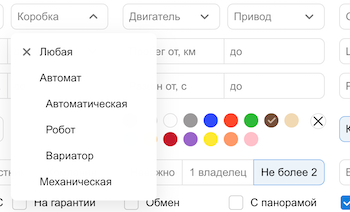

Создадим из данного признака новый признак:
- коробка передач (автомат, механика)

In [69]:
# Создаем колонку transmission со значениями "автомат" и "механическая"
data['transmission'] = data.vehicleTransmission.copy()

data['transmission'].replace(['AUTOMATIC', 'ROBOT', 'VARIATOR',
                              'роботизированная', 'автоматическая', 'вариатор'], "автомат", inplace=True)
data['transmission'].replace(
    ['MECHANICAL', 'механическая'], "механическая", inplace=True)

In [70]:
# В колонке vehicleTransmission почистим данные значениями 'робот', 'автоматическая', 'вариатор' или "механическая"

data['vehicleTransmission'].replace(
    ['AUTOMATIC', 'автоматическая'], "автоматическая", inplace=True)
data['vehicleTransmission'].replace(
    ['ROBOT', 'роботизированная', ], "робот", inplace=True)
data['vehicleTransmission'].replace(
    ['VARIATOR', 'вариатор'], "вариатор", inplace=True)
data['vehicleTransmission'].replace(['MECHANICAL', 'механическая'], "механическая", inplace=True)

In [71]:
# Проверим, какие значения получились
data['transmission'].unique()

array(['механическая', 'автомат', nan], dtype=object)

**color**

Цвет автомобиля.

In [72]:
# Посмотрим на представленные цвета
data.color.unique()

array(['040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB', 'синий', 'чёрный', 'серый',
       'коричневый', 'белый', 'пурпурный', 'бежевый', 'серебристый',
       'красный', 'зелёный', 'жёлтый', 'голубой', 'оранжевый',
       'фиолетовый', 'золотистый', 'розовый'], dtype=object)

In [73]:
# Создаем словать с кодировкой значений в цвета
color_dict = {'040001': 'чёрный', 'EE1D19': 'красный', '0000CC': 'синий', 'CACECB': 'серебристый', '007F00': 'зелёный',
              'FAFBFB': 'белый', '97948F': 'серый', '22A0F8': 'голубой', '660099': 'пурпурный', '200204': 'коричневый',
              'C49648': 'бежевый', 'DEA522': 'золотистый', '4A2197': 'фиолетовый', 'FFD600': 'жёлтый',
              'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

data['color'].replace(to_replace=color_dict, inplace=True)

In [74]:
# Проверяем результат
data.color.unique()

array(['чёрный', 'красный', 'синий', 'серебристый', 'зелёный', 'белый',
       'серый', 'голубой', 'пурпурный', 'коричневый', 'бежевый',
       'золотистый', 'фиолетовый', 'жёлтый', 'оранжевый', 'розовый'],
      dtype=object)

**driveSide**

Расположение руля

In [75]:
data.driveSide.unique()

array(['LEFT', 'RIGHT', 'Левый', 'Правый', nan], dtype=object)

In [76]:
# Заменим анлоязычные значения на русские
data['driveSide'] = data['driveSide'].map(
    {'RIGHT': 'Правый', 'LEFT': 'Левый', 'Правый': 'Правый', 'Левый': 'Левый'})

In [77]:
# уберем верхний регистр
data['driveSide'] = data['driveSide'].str.lower()

**tcp**

Оригинал ПТС

In [78]:
data.tcp.unique()

array(['ORIGINAL', 'DUPLICATE', nan, 'Оригинал', 'Дубликат'], dtype=object)

In [79]:
data[data.train == 0].tcp.head()

89378    Оригинал
89379    Оригинал
89380    Оригинал
89381    Оригинал
89382    Оригинал
Name: tcp, dtype: object

In [80]:
# Заменим анлоязычные значения на русские
data['tcp'] = data['tcp'].map(
    {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат', 'Оригинал': 'Оригинал', 'Дубликат': 'Дубликат'})

In [81]:
# уберем верхний регистр
data['tcp'] = data['tcp'].str.lower()

**bodyType**

Тип кузова.

In [82]:
data.bodyType.value_counts()

внедорожник 5 дв.         92027
седан                     48531
Внедорожник 5 дв.         31885
Седан                     30593
хэтчбек 5 дв.              9288
                          ...  
Кабриолет JCW                 1
Седан T140                    1
Универсал 5 дв. Gracia        1
Минивэн Marco Polo            1
Хэтчбек 5 дв. Long            1
Name: bodyType, Length: 192, dtype: int64

In [83]:
# Приведем значения к нижнему регистру, уберем ряд дубликатов в значениях

data['bodyType'] = data['bodyType'].apply(lambda x: str(x).lower())

### 3.6 Дубликаты

Определим количество дубликатов в данных в части train.

In [84]:
print("Количество дубликатов строк в train части датафрейма:",
      data[data.train == 1].duplicated().sum())

Количество дубликатов строк в train части датафрейма: 138995


In [85]:
# Удалим дубликаты из датасета
data.drop_duplicates(inplace=True)

### 3.7 Анализ пропусков

Посмотрим вцелом на наличие пустых значений и определим стратегию работы с ними.

In [86]:
def intitial_eda_checks(df, missing_percent):
    '''
    Функция принимает на вход датафрейм, а также заданный порог % пустых значений, который хотим обработать. 
    На выход выводит на экран информацию о сумме пустых значений для всех колонок, а также проце
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        series = mask_percent[mask_percent > missing_percent]
        columns = series.index.to_list()

        missing_data = pd.DataFrame(pd.concat(
            [total, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
        print('Сумма и процент значений NaN:\n \n')
        display(missing_data)
    else:
        print('NaN значения не найдены.')

In [87]:
# Запускаем функцию вывода всех пустых значений
print("Пропуски для TEST+TRAIN датафрейов.\n")
intitial_eda_checks(data, 0)

Пропуски для TEST+TRAIN датафрейов.

Сумма и процент значений NaN:
 



,Количество,%
ownershipTime,81330,66.25
ownersCount,11111,9.05
description,3232,2.63
tcp,906,0.74
price,742,0.60
drivetrain,558,0.45
mileage,557,0.45
model,557,0.45
driveSide,557,0.45
enginePower,1,0.00


In [88]:
print("Пропуски для TEST датафрейма.\n")
intitial_eda_checks(data[data.train == 0], 0)

Пропуски для TEST датафрейма.

Сумма и процент значений NaN:
 



,Количество,%
ownershipTime,22691,65.42
tcp,1,0.00


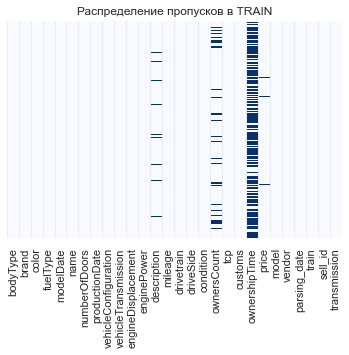

In [89]:
# Посмотрим, как распределены пропуски в части train
ax = plt.axes()
sns.heatmap(data[data.train == 1].isnull(),
            yticklabels=False, cbar=False, cmap='Blues')
ax.set_title('Распределение пропусков в TRAIN')
plt.show()

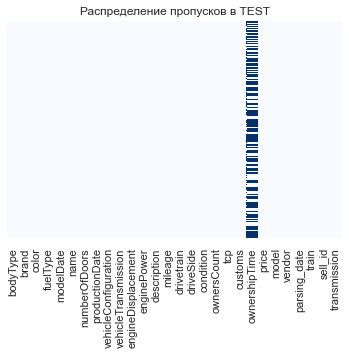

In [90]:
# Посмотрим, как распределены пропуски в части test
ax = plt.axes()
sns.heatmap(data[data.train == 0].isnull(),
            yticklabels=False, cbar=False, cmap='Blues')
ax.set_title('Распределение пропусков в TEST')
plt.show()

В таблице выведена информация по всем пустым значениям для всех столбцов основного рабочего датасета (data).

Выводы и стратегия обработки:
1. В 15 столбцах присутствуют пропуски.
2. Test:
    - [x] tcp: пропуск в одной записи, посмотреть на нее детально, попробовать восстановить или заполнить модой
    - [x] ownershipTime: много пропусков (около 65%), проанализировать с чем скоррелирован признак, попробовать заполнить. Если заполнить не получится, то возможно, удалить из признаков для моделирования.
3. Train + Test:
    - [ ] ownersCount (10554) - можно построить мапинг с медианой/модой по группам в зависимости от года выпуска авто. Заполним пропуски на этапе детального анализа признака.
    - [x] price (410) - значения с пропусками удалить из данных 
    - [x] tcp (310) - поисследовать пропуски и подумать над способами заполнения.
    - [x] есть ряд столбцов, где присутсвует ровно один пропуск. Проверить гипотезу, что пропуски находятся в одной и той же строке.
    - [x] description заполнить не удастся, колонка в таком виде, как есть, будет удаляться.

Займемся обработкой пропусков по описанной выше стратегии.

**price**

In [91]:
# Проверим, что price отсуствует именно в train данных и мы не затроним test
data[data.price.isnull() == True]['train'].value_counts()

1    742
Name: train, dtype: int64

In [92]:
# Удаляем строки с price = NAN
data.dropna(subset=['price'], inplace=True)

**Гипотеза, что NAN с одной строкой - это одна и та же запись**

In [93]:
data[data.modelDate.isnull() == True]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,tcp,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission
24624,nan,HONDA,серебристый,универсал,<NA>,NaN,<NA>,1989,NaN,NaN,...,оригинал,1,None,120000.0,CIVIC,JAPANESE,2020-09-09,1,0,NaN


In [94]:
# Посмотрим, что за строка, где modelDate = NaN
print("Индекс строки к удалению:",
      data[data.modelDate.isnull() == True].index[0])

Индекс строки к удалению: 24624


Действительно, в одной строке очень много пропусков, при этом машина 1989, недорогая. Удаляем.

In [95]:
# Удаляем строку
data.drop([24624], inplace=True)

**tcp**

Проверим гипотезу, что:
- tcp пустой у новых машин
- tcp пустой там, где это дубликат.

In [96]:
# Посмотрим на пример таких данных
data[data.tcp.isnull() == True].sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,tcp,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission
155269,внедорожник 5 дв.,INFINITI,белый,бензин,2017,Infiniti QX50 II,5,2021,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,...,NaN,0,NaN,3720000.0,NaN,JAPANESE,2021-08-30,1,0,автомат
42874,пикап двойная кабина,MITSUBISHI,белый,дизель,2018,2.4d AT (154 л.с.) 4WD,4,2020,PICKUP_TWO AUTOMATIC 2.4d,автоматическая,...,NaN,1,None,2750000.0,L200,JAPANESE,2020-09-09,1,0,автомат
172531,внедорожник 5 дв.,AUDI,чёрный,бензин,2020,Audi Q5 45 TFSI II (FY) Рестайлинг,5,2021,ALLROAD_5_DOORS ROBOT 2.0,робот,...,NaN,0,NaN,5105867.0,NaN,EUROPEAN,2021-08-29,1,0,автомат


In [97]:
# Сгруппируем данные по году выпуска и выведем медианный пробег и кол-во владельцев
data[data.tcp.isnull() == True].groupby('productionDate')[
    'mileage', 'ownersCount'].median()

,mileage
productionDate,
1999,276000.0
2018,0.0
2019,0.0
2020,0.0
2021,NaN


Действительно, выглядит так, что NAN - для новых машин и одной машины с теста. 
Стратегия заполнения:
- для новых авто: новое значение "новая"
- для 10412 из test: попробуем "дубликат"

In [98]:
# Заполняем test значением дубликат
data.tcp.loc[data[(data.tcp.isnull() == True) & (
    data.train == 0)]['tcp'].index[0]] = 'дубликат'

In [99]:
# Смотрим, какой mileage у оставшихся записей. Удостоверимся, что это авто без пробега
data[data.tcp.isnull() == True].mileage.value_counts()

0.0    348
Name: mileage, dtype: int64

In [100]:
# Заполняем значением "новое авто"
data.tcp.fillna('новое_авто', inplace=True)

In [101]:
# Проверяем, что получилось
data.tcp.value_counts()

оригинал      106146
дубликат       15022
новое_авто       843
Name: tcp, dtype: int64

**description**

In [102]:
# добавим колонку в список на удаление перед построением модели
cols_removal.append('description')

**OwnershipTime**

Попробуем восстановить информацию о времени владении, исходя из информации в productionDate.

Создадим на базе признака колонку, в которой поместим инфрмацию о количестве месяцев владения автомобилем.

In [103]:
def num_of_months(row):
    """
    Функция перевеодит формат данных "x лет y месяца(ев)" в количество месяцев.
    Вход: строка series.
    Выход: количество месяцев
    """
    if pd.notnull(row) and row != 'no_data':
        list_ownership = row.split()  # разделяем строку на список из месяца и лет
        if len(list_ownership) == 2:  # если содержится информация только про годы
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])  # переводим год в месяцы
        # случай, когда содержится инфо только про месяц
        # прибавляем к годам*12 количетсво месяцев
        return int(list_ownership[0])*12 + int(list_ownership[3])

In [104]:
# Создаем новый столбец с количеством месяцев владения
data['ownershipTimeMonths'] = data['ownershipTime'].apply(num_of_months)

In [105]:
# Пока заполняем пропуски no_data, далее решаем, что сделать с признаком
data['ownershipTime'] = data['ownershipTime'].fillna('no_data')

In [106]:
# Смотрим, что получилось
data[data.ownershipTime != 'no_data'][[
    'ownershipTime', 'ownershipTimeMonths']].sample(5)

,ownershipTime,ownershipTimeMonths
37952,2 годa и 8 месяцев,32.0
96022,3 года и 7 месяцев,43.0
67527,9 лет и 3 месяца,111.0
57776,2 годa,2.0
3998,3 годa и 10 месяцев,46.0


У 65% записей данные о времени владении отсутсвует. Проверим гипотезу, что есть какая-то взаимосвязь между ownershipTimeMonths и productionDate. Поисследуем, чтобы посмотреть, можем ли заполнить пропуски.

In [107]:
# Извлечм орипнтировочную информацию о количестве месяцев после производства
data['prodTimeMonths'] = data.apply(lambda x: (x['parsing_date'].year - x['productionDate'])*12, axis = 1)

In [108]:
# Посмотрим, как распределены статистики по признакам
data[(data.ownershipTimeMonths.isnull() == False) & (
    data.productionDate != 2020)][['prodTimeMonths', 'ownershipTimeMonths']].describe()

,prodTimeMonths,ownershipTimeMonths
count,41026.000000,41026.000000
mean,129.813582,48.512407
std,78.336214,43.390101
min,0.000000,1.000000
25%,84.000000,16.000000
50%,120.000000,35.000000
75%,168.000000,72.000000
max,1392.000000,514.000000


In [109]:
# Добавим признак, показывающий во сколько раз время после производства больше времени владения
data['prodTime_ownershipTime'] = data.apply(lambda x: x['prodTimeMonths']/x['ownershipTimeMonths'], axis = 1)

In [110]:
# Посмотрим статистики
data.prodTime_ownershipTime.describe()

count    41178.000000
mean         9.176256
std         21.475332
min          0.000000
25%          1.230769
50%          2.666667
75%          7.200000
max        384.000000
Name: prodTime_ownershipTime, dtype: float64

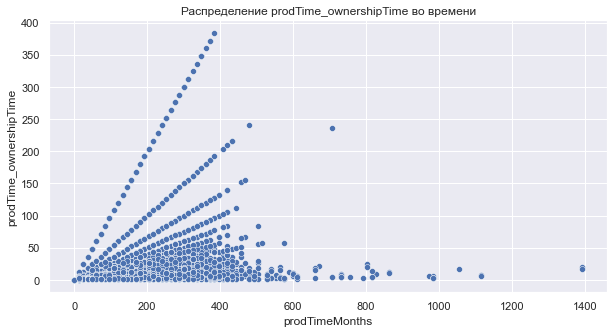

In [111]:
# Посмотрим на графики
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=data, x='prodTimeMonths', y="prodTime_ownershipTime")
ax.set_title('Распределение prodTime_ownershipTime во времени')
plt.show()

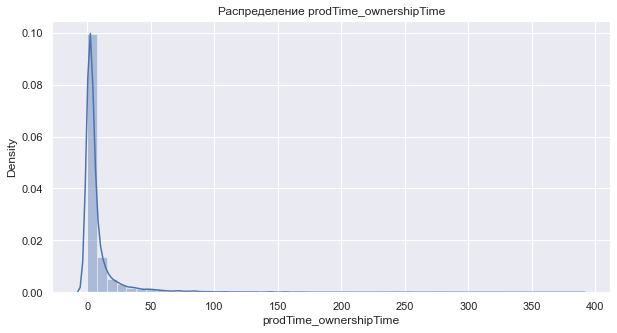

In [112]:
# Посмотрим на распределение признака
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(data['prodTime_ownershipTime'])
ax.set_title('Распределение prodTime_ownershipTime')
plt.show()

Видно, что есть какая-то группировка признака по классам, но пока не понятно, на базе какого признака наблюдается линейная зависимость по коэффициентам соотношения времени владения и времени после производства.

Следующие шаги:
1. План-минимум: заполнить для новых авто NAN нулями, внести признак, что время владения не указано. Возможно, что-то из этого получится. Текущий признак удалить.
2. План-максимум: найти, каким образом заполнить недостающие значения.

In [113]:
# Заполним нулями признак для новых автомобилей
data['ownershipTimeMonths'].loc[(data['mileage'] == 0) & (data['ownershipTimeMonths'].isnull() == True)] = 0

**ownershipTimeIsNull**

Создадим новый признак, который показывает, заполнено ли время владения авто:
- 1 - не заполнено
- 0 - заполнено.

In [114]:
# Создадим новый признак, что время владения не указано
data['ownershipTimeIsNull'] = np.where(data['ownershipTimeMonths'].isnull(), 1, 0)

In [115]:
# Удалим служебные признаки, которые создавали для вычислений
data.drop(['prodTime_ownershipTime', 'prodTimeMonths'], axis = 1, inplace = True)

In [116]:
# Добавим исходную колонку в список на удаление перед построением модели
cols_removal.append('ownershipTime')
cols_removal.append('ownershipTimeMonths')

### 3.8 Извлечение дополнительных признаков из данных

Посмотрим на данные и подумаем, какие дополнительные признаки можно "извлечь" из текущих данных без грубокого фиче инжениринга.

**ownershipTime**


### Детальный анализ признаков

Список вопросов для детального анализа из предварительного анализа:
- [ ] fuelType - разобраться, что такое универсал
- [ ] engineDisplacemen	- разобраться, какие значения, унифицировать и/или сгенерировать новые признаки
- [ ] description - кандидат на удаление, но можно извлечь новые признаки
- [ ] numberOfDoors - разобраться с транспортом 0 дверей

#### Группировка признаков на категориальные, бинарные и числовые

Посмотрим, какие признаки могут относиться к категориальным, бинарным, числовым.

In [117]:
# Посмотрим, сколько уникальных значений
data.nunique(dropna=False)

bodyType                   168
brand                       36
color                       16
fuelType                     5
modelDate                   80
name                      5254
numberOfDoors                5
productionDate              81
vehicleConfiguration      2026
vehicleTransmission          4
engineDisplacement         589
enginePower                399
description             100966
mileage                  24686
drivetrain                   4
driveSide                    3
condition                    2
ownersCount                  5
tcp                          3
customs                      2
ownershipTime              355
price                     8482
model                     1231
vendor                       4
parsing_date                10
train                        2
sell_id                  34687
transmission                 2
ownershipTimeMonths        310
ownershipTimeIsNull          2
dtype: int64

In [118]:
# Выведем пример признаков на экран
data.loc[5]

bodyType                                                            седан
brand                                                                AUDI
color                                                             зелёный
fuelType                                                           бензин
modelDate                                                            1990
name                                                    2.8 MT (174 л.с.)
numberOfDoors                                                           4
productionDate                                                       1993
vehicleConfiguration                                 SEDAN MECHANICAL 2.8
vehicleTransmission                                          механическая
engineDisplacement                                                    2.8
enginePower                                                           174
description             Хорошая комплектация: климат, эл. стекла, эл. ...
mileage                               

In [119]:
# Посмотрим, на колонки, которые планируем в последствие удалить, чтобы не включать их в анализ
print("Признаки для последующего удаления:", cols_removal)

Признаки для последующего удаления: ['customs', 'condition', 'vehicleConfiguration', 'name', 'description', 'ownershipTime', 'ownershipTimeMonths']


Исходя из количества уникальных значений, разделим все признаки на группу.

1. Категориальные признаки: 'bodyType', 'brand', 'color', 'fuelType', 'drivetrain', 'tcp', 'model','vendor', 'automaticType'
2. Бинарные признаки: - 'customs', 'condition' (не алазируем, т.к. все данные представленны одним значением признака), 'ownershipTimeIsNull', 'transmission', 'driveSide'
3. Числовые признаки: 'modelDate', 'numberOfDoors', 'productionDate', 'engineDisplacement', 'enginePower', 'mileage', 'ownersCount'
4. Даты: -
5. Служебный признак (не анализируем): 'train', 'sell_id'
6. Целевой: 'price'

In [120]:
# бинарные признаки
bin_cols = ['ownershipTimeIsNull', 'driveSide', 'transmission']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'drivetrain', 'tcp', 'model',
            'engineDisplacement', 'vendor', 'vehicleTransmission', 'numberOfDoors', 'ownersCount']

# числовые переменные
num_cols = ['modelDate', 'productionDate',
            'enginePower', 'mileage']

# сервисные переменные
service_cols = ['train', 'sell_id']

# целевая переменная
target_col = ['price']

all_cols = bin_cols + cat_cols + num_cols + service_cols + target_col

print("Кол-во столбцов, для дальнейшей работы после предварительного анализа:", len(all_cols))

Кол-во столбцов, для дальнейшей работы после предварительного анализа: 22


#### Числовые переменные: распределение, корреляционный анализ, определение значимости

###### Распределние численных признаков.

In [121]:
""" # Построим распределение основных числовых признаков

print("Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(4, 3, figsize=(30, 40))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(data[col], ax=axes[i])
    i = i + 1
    sns.boxplot(data[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=data[data['train'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1
"""

' # Построим распределение основных числовых признаков\n\nprint("Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной")\n\nfig, axes = plt.subplots(4, 3, figsize=(30, 40))\nplt.subplots_adjust(wspace=0.5)\naxes = axes.flatten()\ni = 0\n\nfor col in num_cols:\n    sns.distplot(data[col], ax=axes[i])\n    i = i + 1\n    sns.boxplot(data[col], ax=axes[i])\n    i = i + 1\n    sns.scatterplot(data=data[data[\'train\'] == 1],\n                    x=col, y="price", ax=axes[i])\n    i = i + 1\n'

In [122]:
print("Основные статистики для числовых признаков.")
display(data[num_cols].describe())

Основные статистики для числовых признаков.


,modelDate,productionDate,enginePower,mileage
count,122011.000000,122011.000000,122011.000000,121516.000000
mean,2007.979469,2010.239388,176.386326,145711.380929
std,7.394479,7.008148,86.013121,101701.727285
min,1904.000000,1904.000000,11.000000,0.000000
25%,2004.000000,2007.000000,117.000000,75000.000000
50%,2009.000000,2011.000000,150.000000,138000.000000
75%,2013.000000,2015.000000,211.000000,200000.000000
max,2021.000000,2021.000000,800.000000,1000000.000000


Выводы:

1. После построения гистограмм стало очевидно, что распределения основных числовых переменных имеют тяжёлый левый или правый хвост, влияет на разбежку между средним и медианой: 
    - для того, чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных
    - поработать с выбросами
    - подумать про группировку признаков по категориям.
2. Распределние modelDate, productionDate очень схожи:
    - проверить на признаки на мультиколлинеарность во время корреляционного анализа
    - видно, что в среднем productionDate чуть позже, чем modelDate во времени, т.е. производство приосходит чуть с запозданием, что логично. Можно добавить новый признак - насколько новая модель, т.е. через сколько лет после появления модели был выпущен автомобиль.
3. mileage: есть пик в 0 - признак нового авто.
4. enginePower: 11 лс - что это за авто? Поисследовать
5. Взаимосвязь признаков с таргетом:
    - наблюдается прямая корреляция цены от года модели и года выпуска с исключениями для особо раритетных автомобилей (~до 1975 года).
    - наблюдается обратная корреляция цены от пробега авто
    - цена от мощности вдигателя зависит, но не так явно, как от других переменных.

###### Корреляционный анализ.

Оценим корреляцию Пирсона для непрерывных переменных. Cильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

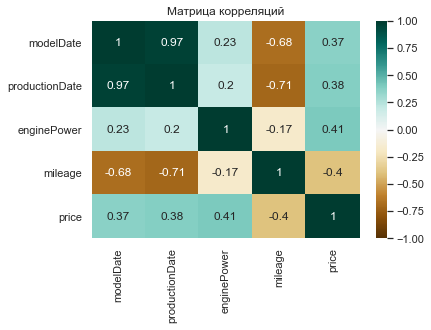

In [123]:
# Построим матрицу корреляций
heatmap = sns.heatmap(data[num_cols + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций')
plt.show()

Вывод: 
1. Взаимосвязь пар числовых признаков по Пирсону достаточно сильная для productionDate, modelDate. При этом, у productionDate чуть большая корреляция с целевой переменной. Удалим признак modelDate.
2. Достаточно сильная корреляция между productionDate и meleage - чем меньше год выпуска, тем больше пробег
3. У всех числовых признаков достаточно высокая корреляция с целевой переменной, это хорошо.

In [124]:
# Добавляем modelDate в список колонок на удаление.
cols_removal.append('modelDate')

###### Детальный анализ

Посмотрим более пристально на признаки, которые не исключили из анализа.

**mileage**

Дополнительно поисследуем признак.

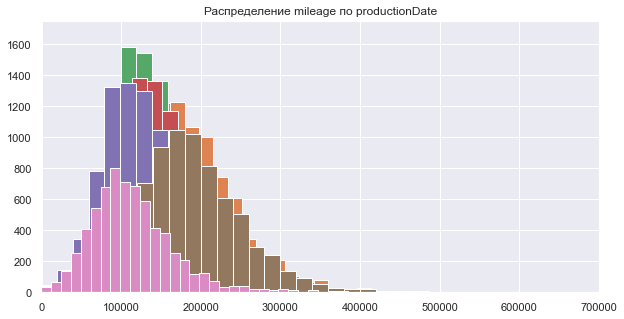

In [125]:
# посмотрим на топ 5 годов выпуска авто
fig, ax = plt.subplots(figsize=(10, 5))

for x in (data['productionDate'].value_counts())[0:7].index:
    data['mileage'][data['productionDate'] == x].hist(bins=50)

ax.set_xlim(0, 700000)
ax.set_ylim(0, 1750)

plt.title("Распределение mileage по productionDate")
plt.show()

Получается, что mileage имеет нормальное распределение, просто чем старше автомобиль, тем больше пробег, из-за мы видим смещение.

Чтобы скорректировать признак и сделать его более информативным создадим новый признак в разделе создания признаков: km_per_year - показывает, сколько км в год проезжал автомобиль. Вычисляется, как mileage/productionDate(years) или mileage/ownershipTime. Решить, какой метод использовать.

**enginePower**

Нужно поисследовать странное минимальное значение мощности.

In [126]:
print("Значение мощности двигателя (л.с.) на TEST")
display(data[data.train == 0]['enginePower'].describe())

print("\nЗначение мощности двигателя (л.с.) на TRAIN")
display(data[data.train == 1]['enginePower'].describe())

Значение мощности двигателя (л.с.) на TEST


count    34686.000000
mean       188.194142
std         89.087035
min         30.000000
25%        125.000000
50%        169.000000
75%        233.000000
max        639.000000
Name: enginePower, dtype: float64


Значение мощности двигателя (л.с.) на TRAIN


count    87325.000000
mean       171.696192
std         84.304055
min         11.000000
25%        115.000000
50%        150.000000
75%        200.000000
max        800.000000
Name: enginePower, dtype: float64

Видим, что в Test минимум - больше, а максимум - меньше. Посмотрим, что это за авто и сколько их.

In [127]:
print("Строки, в которых мощность двигателя меньше 30 л.с.")
data[data.enginePower < data[data.train == 0]['enginePower'].min()]

Строки, в которых мощность двигателя меньше 30 л.с.


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission,ownershipTimeMonths,ownershipTimeIsNull
22691,кабриолет,FORD,зелёный,бензин,1908,2.9 MT (20 л.с.),2,1923,CABRIO MECHANICAL 2.9,механическая,...,no_data,3800000.0,MODEL_T,AMERICAN,2020-09-09,1,0,механическая,NaN,1
22692,кабриолет,FORD,чёрный,бензин,1908,2.9 MT (20 л.с.),2,1924,CABRIO MECHANICAL 2.9,механическая,...,no_data,3000000.0,MODEL_T,AMERICAN,2020-09-09,1,0,механическая,NaN,1
59955,купе,RENAULT,белый,электро,2011,Electro AT (13 кВт),2,2012,COUPE AUTOMATIC Electro,автоматическая,...,1 год и 3 месяца,449000.0,TWIZY,EUROPEAN,2020-09-09,1,0,автомат,15.0,0
59956,купе,RENAULT,чёрный,электро,2011,Electro AT (9 кВт),2,2016,COUPE AUTOMATIC Electro,автоматическая,...,1 год и 4 месяца,549000.0,TWIZY,EUROPEAN,2020-09-09,1,0,автомат,16.0,0


In [128]:
print("Строки, в которых мощность двигателя более 639 л.с.")
data[data.enginePower > data[data.train == 0]['enginePower'].max()]

Строки, в которых мощность двигателя более 639 л.с.


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission,ownershipTimeMonths,ownershipTimeIsNull
18731,купе srt,DODGE,синий,бензин,2014,Hellcat 6.2 AT (717 л.с.),2,2016,COUPE AUTOMATIC Hellcat,автоматическая,...,1 год и 6 месяцев,6500000.0,CHALLENGER,AMERICAN,2020-09-09,1,0,автомат,18.0,0
18733,купе srt,DODGE,серый,бензин,2014,Hellcat 6.2 AT (717 л.с.),2,2016,COUPE AUTOMATIC Hellcat,автоматическая,...,no_data,5990000.0,CHALLENGER,AMERICAN,2020-09-09,1,0,автомат,NaN,1
18832,пикап двойная кабина crew cab trx,DODGE,серый,бензин,2018,Crew Cab TRX 6.2 AT (702 л.с.) 4WD,4,2020,PICKUP_TWO AUTOMATIC Crew,автоматическая,...,no_data,14433255.0,RAM,AMERICAN,2020-09-09,1,0,автомат,0.0,0
23483,купе,FORD,красный,бензин,2009,Shelby GT500 5.8 MT (662 л.с.),2,2013,COUPE MECHANICAL Shelby,механическая,...,no_data,9980000.0,MUSTANG,AMERICAN,2020-09-09,1,0,механическая,NaN,1
23485,купе,FORD,чёрный,бензин,2009,Shelby GT500 5.8 MT (662 л.с.),2,2013,COUPE MECHANICAL Shelby,механическая,...,no_data,9000000.0,MUSTANG,AMERICAN,2020-09-09,1,0,механическая,NaN,1
32411,внедорожник 5 дв. trackhawk,JEEP,белый,бензин,2013,Trackhawk 6.2 AT (717 л.с.) 4WD,5,2019,ALLROAD_5_DOORS AUTOMATIC Trackhawk,автоматическая,...,no_data,10300000.0,GRAND_CHEROKEE,AMERICAN,2020-09-09,1,0,автомат,0.0,0
57242,седан,PORSCHE,серый,электро,2019,Turbo S Electro AT (561 кВт) 4WD,4,2020,SEDAN AUTOMATIC Turbo,автоматическая,...,no_data,16601327.0,TAYCAN,EUROPEAN,2020-09-09,1,0,автомат,0.0,0
57246,седан,PORSCHE,белый,электро,2019,Turbo Electro AT (501 кВт) 4WD,4,2020,SEDAN AUTOMATIC Turbo,автоматическая,...,8 месяцев,13500000.0,TAYCAN,EUROPEAN,2020-09-09,1,0,автомат,8.0,0
83909,внедорожник 5 дв.,MERCEDES,чёрный,бензин,2018,Brabus 700 4.0 AT (700 л.с.) 4WD,5,2020,ALLROAD_5_DOORS AUTOMATIC Brabus,автоматическая,...,no_data,29300000.0,G_KLASSE_AMG,EUROPEAN,2020-09-09,1,0,автомат,0.0,0
83976,внедорожник 5 дв.,MERCEDES,чёрный,бензин,2018,Brabus 800 4.0 AT (800 л.с.) 4WD,5,2020,ALLROAD_5_DOORS AUTOMATIC Brabus,автоматическая,...,no_data,31600000.0,G_KLASSE_AMG,EUROPEAN,2020-09-09,1,0,автомат,0.0,0


In [129]:
# Таких строк немного, удалим из из дальнейшего анализа
data.drop(data[(data.enginePower > data[data.train == 0]
                ['enginePower'].max()) | (data.enginePower < data[data.train == 0]
                                          ['enginePower'].min())].index, inplace=True)

**productionDate/modelDate**

Посмотрим повнимательнее на признак и попробуем проанализировать поглубже.

In [130]:
print("Значение года производства авто на TEST")
display(data[data.train == 0]['productionDate'].describe())

print("\nЗначение года производства авто на TRAIN")
display(data[data.train == 1]['productionDate'].describe())

Значение года производства авто на TEST


count    34686.000000
mean      2009.264602
std          7.047661
min       1904.000000
25%       2006.000000
50%       2011.000000
75%       2014.000000
max       2020.000000
Name: productionDate, dtype: float64


Значение года производства авто на TRAIN


count    87311.000000
mean      2010.627687
std          6.942164
min       1904.000000
25%       2007.000000
50%       2011.000000
75%       2016.000000
max       2021.000000
Name: productionDate, dtype: float64

Минимальные значения, максимальные, медианные и среднии достаточно близки.

Посмотрим на раритетные автомобили (30 летние машины, согласно классификации FIVA (Fédération Internationale des Véhicules Anciens), см https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C#%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F).

Можно будет добавить признак rarity.

In [131]:
# Посмотрим, сколько таких записей
print(f"В датасете содержится {len(data[data.productionDate < (data['parsing_date'].max().year-30)]['productionDate'])} раритетных автомобилей.")

В датасете содержится 1451 раритетных автомобилей.


Детальнее посмотрим, как падает цена в зависимости от productionDate.

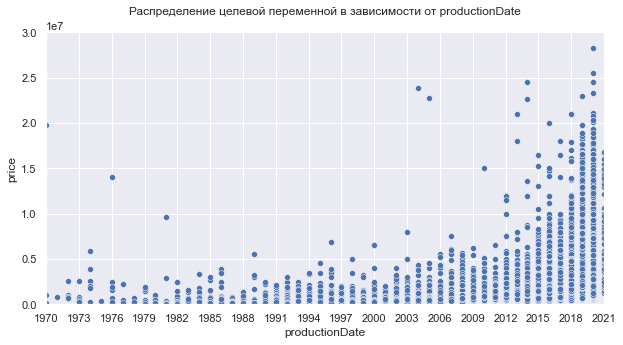

In [132]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim(1970, 2021)
ax.set_ylim(0, 30000000)
ax.set_xticks(np.arange(1970, 2022, 3))

sns.scatterplot(data=data[data['train'] == 1], x='productionDate', y="price")

plt.title("Распределение целевой переменной в зависимости от productionDate\n")
plt.show()

Можно найти много информации, что цена автомобиля значительно падает после 3-5 лет эксплуатации. На графиках даная динамика тоже прослеживается. Идеи для новых признаков:
- prodDate_3Y - признак, что автомобилю уже 3 года
- prodDate_5Y - признак, что автомобилю уже 5 лет.

#### Категориальные и бинарные переменные: конвертация в числовые

##### Распределение признаков

Посмотрим на распределение признаков.

In [133]:
"""
# Построим распределение основных бинарных и категориальных признаков
print("Распределение бинарных и категориальных признаков. Нажимите дважды для увелечения.")

fig, axes = plt.subplots(5, 3, figsize=(20, 35))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in (bin_cols + cat_cols):
    sns.histplot(data=data, x=data[col], ax=axes[i],
                 stat='count', bins=data[col].nunique())
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.title(col)
    i = i + 1
"""

'\n# Построим распределение основных бинарных и категориальных признаков\nprint("Распределение бинарных и категориальных признаков. Нажимите дважды для увелечения.")\n\nfig, axes = plt.subplots(5, 3, figsize=(20, 35))\nplt.subplots_adjust(wspace=0.5)\naxes = axes.flatten()\ni = 0\n\nfor col in (bin_cols + cat_cols):\n    sns.histplot(data=data, x=data[col], ax=axes[i],\n                 stat=\'count\', bins=data[col].nunique())\n    plt.tight_layout()\n    plt.xticks(rotation=45)\n    plt.title(col)\n    i = i + 1\n'

In [134]:
def get_boxplot(column):
    """
    Функция для отрисовки коробочной диаграммы для нечисловых признаков.
    На вход получаем список колонок для отрисовки. 
    Отрисовываем относительно целевой переменной pricing, ограниченной по квантилю.
    """
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='price',
                data=data[data['train'] == 1],
                ax=ax)
    plt.xticks(rotation=45)
    # поскольку в price много выбросов, огриничимся 75% квантилем
    ax.set_ylim(0, (data.price.quantile(0.75) + 6*(data.price.quantile(0.75) - data.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column)
    plt.show()

In [135]:
"""
for col in (bin_cols + cat_cols):
    get_boxplot(col)"""

'\nfor col in (bin_cols + cat_cols):\n    get_boxplot(col)'

Выводы по всем графикам:
1. Полностью сбалансированные признаки отсутсвуют.
2. Особо несбалансированные признаки: 
    - [ ] driveSide - правосторонни машины в большинстве => поисследовать, есть ли левосторонние машины в тесте. Если нет, то удалить признак
    - [ ] bodyType - огромное количество категорий, многие категории представлены единичными автомобилями => переструктурировать категории, уменьшить их количество, провести повторный анализ
    - [ ] brand - много категорий, заметно, что есть массовые, среднепопулярные и редкие бренды авто. Поисследовать дополнительно и подумать над созданием новых признаков (престижные авто/люкс, популярные и т.д.)
    - [ ] color - есть популярные цвета (черный, белый, серый, серебристый, синий) и редкие. Посмотреть дополнительно и создать новый признак о популярности цвета
    - [ ] fuelType - есть типы топлива, которые в явном меньшинстве. Поисследовть и подумать, стоит ли делать группировку непопулярных типов топлива
    - [ ] tcp - признак нового авто, возможно, вынести в отдельный признак
    - [ ] model - очень много уникальных категорий, подумать, можно ли как-то доработать признак. Подумать про объединение brand + model
    - [ ] engineDisplacement - очень много уникальных категорий, подумать, можно ли как-то доработать признак
    - [ ] numberOfDoors - малое количество машин в 0-3 - изучить детальнее
    - [ ] ownersCount - привалирует 3 и более, но были пропуски, необходимо решить, как заполнять.

3. Сбалансированные признаки с заметно превалирующим классом:
    - ownershipTimeIsNull - большая часть записей без указания времени владения
    - transmission - автомат превалирует
    - drivertrain - передний привод встречается чаще всего
    - vendor - большее количество автомобилей европейского региона
4. Зависимость с целевой переменной:
    - ownershipTimeIsNull: машины без указания времени владения в среднем дешевле, чем машины с указанием времени владения
    - driveSide: авто с правосторонним рулем в среднем дешевле машин с левосторонним рулем
    - transmission: авто с АТ коробкой намного дороже MT, как и сам диапазон цен
    - [ ] bodyType: анализ затруднителен, нужно дополнительно обрабатывать
    - brand: большая разбежка цен от бренда. Выделяются престижные авто (porche, Cadillac, bmw, and Rover, Lexus и др), а есть дешевый сегмент (азиатские авто - Cherry, Daewoo, Great wall и др.). Также видны бренды, которые выпускают дорогие авто, но и есть модели для более дешевого сегмента.
    - color: цены зависят от цвета, но большие цены представлены у цветов, количество авто по которым больше. 
    - [ ] fuelType: очень дорогие машины электро и дизель, возможно выделить отдельный признак, что машина “электрокар”
    - drivetrain: полноприводные машины дороже всех, заднеприводные машины в среднем дешевле переднеприводных
    - [ ] tcp: признак “новый авто” заметно повышает среднюю цену, однозначно вынести в отдельный признак. Авто с дубликатом ПТС дешевле чем те, что с оригиналом
    - [ ]  model и engineDisplacement - так много данных, что анализ затруднителен. Сделать повторный после обработки
    - vendor: в среднем, европейские и японские машины дороже американских и азиатских
    - [ ] vehicleTransmission: в среднем разновидности автоматов особо не влияют на цену, проверить значимость признака тестом Стьюдента. Потенциально на исключение.
    - numberOfDoors: в среднем самые дорогие авто - 2-х дверные, затем 5-дверные.
    - ownersCount: чем больше владельцев, тем ниже средняя цена авто.

##### Преобразование бинарных переменных в числа
Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа. Применим LabelEncoder ко всему набору бинарных переменных.

In [170]:
data['driveSide'].fillna(data['driveSide'].mode()[0], inplace = True)

In [171]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# Убедимся в преобразовании
data[bin_cols].sample(6)

,ownershipTimeIsNull,driveSide,transmission,prodDate_3Y,prodDate_5Y
58530,1,0,1,1,1
36576,1,0,0,1,1
97858,0,0,0,1,1
43765,1,0,1,1,1
27171,0,0,0,1,1
102664,0,0,0,1,1


##### Корреляционный анализ
Оценим корреляцию Пирсона для категориальных и бинарных переменных. Cильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

Text(0.5, 1.0, 'Матрица корреляций для категориальных и бинарных признаков.')

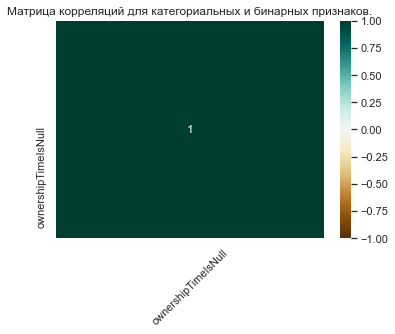

In [137]:
# Построим матрицу корреляций
#plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(data[bin_cols + cat_cols].corr(),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.xticks(rotation=45)
heatmap.set_title('Матрица корреляций для категориальных и бинарных признаков.')

Выводы:

#### Анализ целевой переменной: price

Проанализируем целевую переменную 'price'.

In [138]:
# Посмотрим на основные статистики
print(data[data.train == 1]['price'].describe())

count    8.731100e+04
mean     1.271269e+06
std      1.946661e+06
min      1.600000e+04
25%      3.500000e+05
50%      6.490000e+05
75%      1.399999e+06
max      9.900000e+07
Name: price, dtype: float64


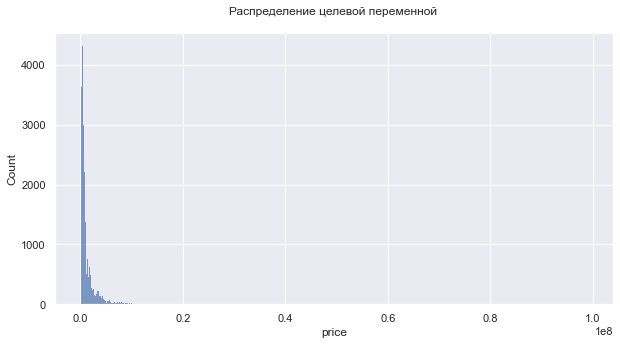

In [139]:
# Посмотрим на распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data.train == 1], x='price')
plt.title("Распределение целевой переменной \n")
plt.show()

Распределение цены с очень сильным правым хвостом, попробуем добавить доп. целевой признак, взяв логорифм от цены.

In [140]:
# Добавляем новый признка
data['price_log']=data['price'].apply(lambda x: np.log(x))

# Добавим новый признак в список целевых
target_col.append('price_log')

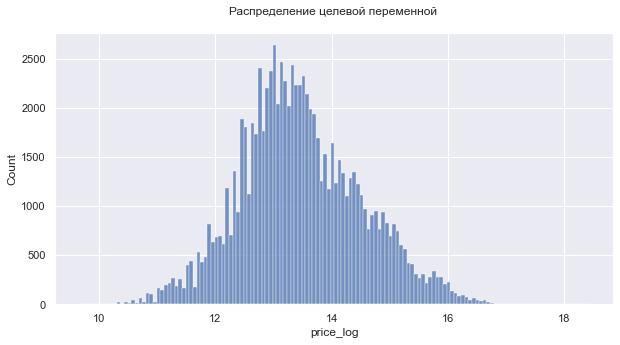

In [141]:
# Посмотрим, как изменилось распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data.train == 1], x='price_log')
plt.title("Распределение целевой переменной \n")
plt.show()

Вывод: распределение выглядит, как нормальное. Можно будет попробовать использовать для моделирования.

**TO DO** 

Цена с учетом курса доллара

### Анализ выбросов

Проведем поиск, анализ и обработку выбросов.

In [142]:
def iqr_analysis(series, mode=False):
    """
    Функция выводит инфорамцию о границах выборосов для признака.
    Если mode = True, возвращается верхняя и нижняя границы выбросов. Иначе, просто выводится информация на экран.
    """
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if mode:
        return f, l

    print(
        "\n25-й перцентиль: {},".format(perc25),
        "\n75-й перцентиль: {},".format(perc75),
        "\nIQR: {}, ".format(IQR),
        "\nГраницы выбросов: [{f}, {l}].".format(
            f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR),
        "\n\nМинимальное значение признака: {}.".format(series.min()),
        "\nМаксимальное значение признака: {} .\n".format(series.max()))

    if series.min() < f:
        print("Найдены выбросы по нижней границе признака! Количество: {}, {}%".format(series.where(
            series < f).count(), round(series.where(series < f).count()/series.count()*100, 2)))
    if series.max() > l:
        print("Найдены выбросы по верхней границе признака! Количество: {}, {}%".format(series.where(
            series > l).count(), round(series.where(series > l).count()/series.count()*100, 2)))

In [143]:
# Проанализируем выбросы для бинарных и номинативных признаков
print("Отчет о наличии выбросов в датасете.\n")
for col in (bin_cols + num_cols + target_col):
    print("\nПризнак: ", col)
    iqr_analysis(data[col])
    print("-" * 100)

Отчет о наличии выбросов в датасете.


Признак:  ownershipTimeIsNull

25-й перцентиль: 0.0, 
75-й перцентиль: 1.0, 
IQR: 1.0,  
Границы выбросов: [-1.5, 2.5]. 

Минимальное значение признака: 0. 
Максимальное значение признака: 1 .

----------------------------------------------------------------------------------------------------

Признак:  driveSide


TypeError: can't multiply sequence by non-int of type 'float'

Посмотрим детальнее на признаки, где были найдены выбросы. Основная идея: сравнить мин/макс границы по test датасету и удалить лишние данные, если их объем не очень большой.

### Генерация новых признаков

Идеи по генерации новых признаков по результатам EDA:
- [x] km_per_year - показывает, сколько км в год проезжал автомобиль. Вычисляется, как mileage/productionDate(years) или mileage/ownershipTime. Решить, какой метод использовать
- [x] carNovelty - показывает, через сколько лет после выхода модели был выпущен автомобиль, т.е. modelDate - productionDate. Гипотеза, что чем меньше это число, тем выше будет цена
- [x] rarity - признак, показывающий, что автомобиль раритетный (ему более 30 лет)
- [x] prodDate_3Y - признак, что автомобилю уже 3 года
- [x] prodDate_5Y - признак, что автомобилю уже 5 лет.

**km_per_year**

Пробег авто км/год.

In [144]:
def km_per_year(row):
    """
    Функция делает пересчет км пробега автомобиля в года после года производства автомобиля.
    Вход: строка датафрейма.
    Выход: информация о км/год.
    """
    if row['mileage'] != 0:
        # обрабатываем случаи, когда мошина произведена в год сбора данных, чтоб не делить на 0
        if row['parsing_date'].year - row['productionDate'] == 0:
            return row['mileage']
        else:
            return row['mileage']/(row['parsing_date'].year - row['productionDate'])
    return 0  # возвращаем 0, если машина без пробега (новая

In [145]:
# Добавим дополнительный признак 'km_per_year', который равен пробегу, поделенному на возраст авто,
data['km_per_year'] = data.apply(km_per_year, axis =1)

In [146]:
# добавляем новые признак
num_cols.append('km_per_year')

**carNovelty**

Новизна машины: через сколько лет после появления модели авто была произведена машина. 

In [147]:
# Добавим'dateModelProdDiff', равный разнице между годом выпуска авто и годом начала производства модели
data['carNovelty'] = data['productionDate'] - data['modelDate']

In [148]:
# Посмотрим, что получилось
data[['productionDate', 'modelDate', 'mileage', 'km_per_year', 'carNovelty']].sample(5)

,productionDate,modelDate,mileage,km_per_year,carNovelty
103796,2006,2006,152300.0,10878.571429,0
66136,2007,2006,136000.0,10461.538462,1
100255,2013,2009,61000.0,8714.285714,4
2232,2006,2004,290000.0,20714.285714,2
10154,2007,2006,198000.0,15230.769231,1


In [149]:
# Заменим отрицательные значение на 0
data['carNovelty'] = data['carNovelty'].apply(lambda x: 0 if x<0 else x)

In [150]:
data.carNovelty.unique()

array([ 1,  4,  3,  2,  5,  0,  7,  6,  8, 10, 11,  9, 12, 18, 15, 13, 14,
       21, 17, 22, 35, 16, 46, 42, 34, 24, 29, 27, 40])

In [151]:
# добавляем новые признак
num_cols.append('carNovelty')

**rarity** 

Раритетные авто (более 30 лет). Строим на базе modelDate.

Значения:
* 5 - авто нераритетный
* 4 - Class F — с 1 января 1961 по 31 декабря 1970
* 3 - Class E (Post War) — с 1 января 1946 по 31 декабря 1960
* 2 - Class D (Post Vintage) — с 1 января 1931 по 31 декабря 1945
* 1 - Class C (Vintage) — с 1 января 1919 по 31 декабря 1930
* Class B (Veteran) — с 1 января 1905 по 31 декабря 1918 (таких авто в выборке нет)
* 0 - Class A (Ancestor) — выпуска до 31 декабря 1904 года.

In [152]:
# Зададим основные раритетные категории
rar_cat = pd.cut(data.modelDate, bins=[0, 1905, 1919, 1931, 1946, 1961, 1971, 2022],
                 labels=['Class A (Ancestor)', 'Class B (Veteran)', 'Class C (Vintage)', 'Class D (Post Vintage)', 
                         'Class E (Post War)', 'class F', 'нераритетный'])
data.insert(20, 'rarity', rar_cat)

In [153]:
# Преобразуем признак age_group в числовой
# label_encoder = LabelEncoder()
# data['rarity'] = label_encoder.fit_transform(data['rarity'])

In [154]:
# Посмотрим на результат
print("Количество автомобилей по раритетности с указанием диапазонов годов моделей")
data.groupby('rarity')['modelDate'].agg(['min', 'max', 'count'])

Количество автомобилей по раритетности с указанием диапазонов годов моделей


,min,max,count
rarity,,,
Class A (Ancestor),1904,1904,2
Class B (Veteran),<NA>,<NA>,0
Class C (Vintage),1927,1927,3
Class D (Post Vintage),1932,1938,37
Class E (Post War),1948,1961,47
class F,1963,1971,40
нераритетный,1972,2021,121868


In [155]:
# Посмотрим на медианную цену по группам
print("Медианная цена по групам раритетности")
data.groupby('rarity')['price'].agg(['median'])

Медианная цена по групам раритетности


,median
rarity,
Class A (Ancestor),6000000.0
Class B (Veteran),NaN
Class C (Vintage),4500000.0
Class D (Post Vintage),550000.0
Class E (Post War),2000000.0
class F,1000000.0
нераритетный,400000.0


In [156]:
# Добавим новый признак к категориальным
cat_cols.append('rarity')

**prodDate_3Y, prodDate_5Y**

- prodDate_3Y - признак, что автомобилю уже 3 года
- prodDate_5Y - признак, что автомобилю уже 5 лет.

In [157]:
def prod_date_range (row, year_lim):
    """
    Создает столбец с информацией, старше ли авто, чем year_lim.
    Вход: строка, установленный лимит.
    Выход: 1 - если авто старше, 0 - если нет.
    """
    if (row['parsing_date'].year-row['productionDate']) >= year_lim:
        return 1
    return 0

In [158]:
# Добавляем новые признаки
#data['prodDate_3Y'] = data['productionDate']>=(current_year-3)
#data['prodDate_5Y'] = (data['productionDate']>=current_year-5)&(data['productionDate']<current_year-3)

data['prodDate_3Y'] = data.apply(prod_date_range, year_lim = 3, axis =1)
data['prodDate_5Y'] = data.apply(prod_date_range, year_lim = 5, axis =1)

In [159]:
# Проверяем результат
data[['prodDate_3Y', 'prodDate_5Y', 'productionDate', 'parsing_date']].sample(3)

,prodDate_3Y,prodDate_5Y,productionDate,parsing_date
98815,0,0,2019,2020-10-19
53006,1,1,2010,2020-09-09
88618,1,1,1988,2020-09-09


In [160]:
# Добавляем новые признаки
bin_cols.append('prodDate_3Y')
bin_cols.append('prodDate_5Y')

### Анализ взаимосвязи признаков между собой


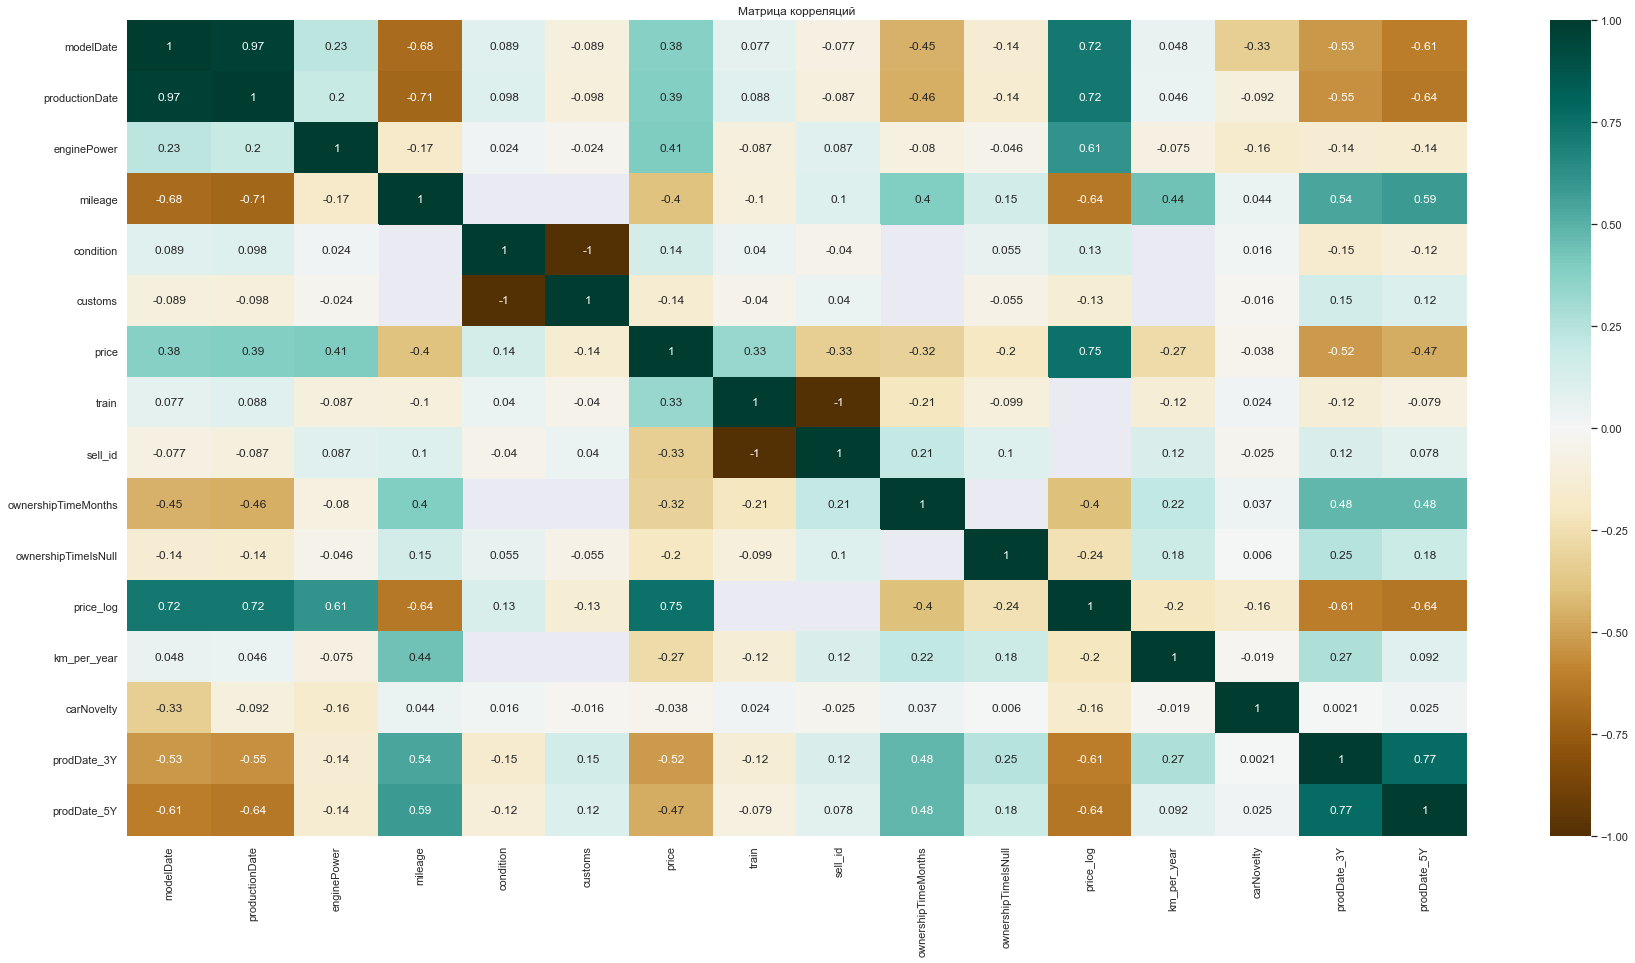

In [161]:
# Построим матрицу корреляций
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций')
plt.show()

### Анализ взаимосвязи признаков с таргетом

### Препроцессинг перед моделированием

#### Удаление признаков перед моделированием

In [162]:
# удаляем признаки, которые решили удалить по ходу анализа
data.drop(cols_removal, axis=1, inplace=True)

#### Label Encoding

In [172]:
# ВРЕМЕНО пропуски заполнили медианой
data['ownersCount'].fillna(data['ownersCount'].median(), inplace = True)

TypeError: could not convert string to float: '3 или более'

In [173]:
data.drop('ownersCount', axis=1, inplace=True)

In [174]:
# Labels encoding
cols_to_encode = list(set(data.columns) & set(cat_cols))
for colum in cols_to_encode:
    data[colum] = data[colum].astype('category').cat.codes

**One-Hot Encoding**

In [ ]:
""" 
# Попробуем OneHotEncoder для кодирования категориальных признаков
cols_to_encode = list(set(data.columns) & set(cat_cols))

ohe = OneHotEncoder(sparse=False)

for col in cols_to_encode:
    df_one = pd.DataFrame(ohe.fit_transform(data[[col]]))
    df_one.columns = ohe.get_feature_names([f'hot_{col}'])
    data = data.drop(col, axis=1)  # удаляем колонку, которую кодировали
    data = pd.concat([data.reset_index(drop=True), df_one.reset_index(drop=True)], axis=1)
"""

**Стандартизация числовых признаков**

In [ ]:
# Стандартизация числовых переменных
#cols_to_scale = list(set(data.columns) & set(num_cols))
#data[cols_to_scale] = StandardScaler().fit_transform(data[cols_to_scale].values)

####   Выделим тестовую и тренировочную части


In [ ]:
#columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage', 'train', 'price', 'price_log']
#columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage', 'train', 'price', 'price_log',
#           'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'enginePower',  'drivetrain', 'driveSide',
#           'ownersCount','tcp', 'rarity', 'model', 'vendor', 'sell_id', 'transmission', 'ownershipTimeIsNull', 'km_per_year',
#           'prodDate_3Y', 'prodDate_5Y', 'carNovelty']
#mod_df = data[columns].copy()
#data = data[columns].copy()

In [175]:
#X = mod_df.query('train == 1').drop(['train', 'price', 'price_log'], axis=1)
#X_sub = mod_df.query('train == 0').drop(['train', 'price', 'price_log'], axis=1)

X = data.query('train == 1').drop(['train', 'price', 'price_log'], axis=1)
X_sub = data.query('train == 0').drop(['train', 'price', 'price_log'], axis=1)

In [176]:
#y = mod_df[mod_df.train == 1]['price']
y = data[data.train == 1]['price']

In [177]:
X.shape, X_sub.shape, y.shape

((87311, 24), (34686, 24), (87311,))

#### Train Split

In [178]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 5. Model 1. Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [179]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [180]:
# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 75.05%


# 6. Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [181]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [182]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 15.95%


Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [183]:
np.log(y_train)

1095     12.043554
81669    13.721200
13774    12.429216
9899     14.777539
62493    13.353475
           ...    
6714     14.316286
57556    13.652992
80396    15.873345
920      12.429216
16593    12.043554
Name: price, Length: 69848, dtype: float64

In [184]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          # cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_2_baseline.model')

In [185]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [186]:
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.72%


Как видим точность возросла до 15%, а что будет на ЛБ?

# Model 3. Lazypredict


In [187]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [188]:
#import lazypredict

In [189]:
#from lazyp?redict.Supervised import LazyRegressor

#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

# 7. Submission

In [190]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.558475e+05
1,1100549428,8.423444e+05
2,1100658222,8.707624e+05
3,1100937408,6.613106e+05
4,1101037972,6.659124e+05
5,1100912634,6.812173e+05
6,1101228730,6.420751e+05
7,1100165896,4.042031e+05
8,1100768262,1.523496e+06
9,1101218501,8.831421e+05


В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* [x] Спарсить свежие данные 
* [ ] Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* [ ] Сгенерировать новые признаки
* [ ] Попробовать подобрать параметры модели
* [ ] Попробовать другие алгоритмы и библиотеки ML
* [ ] Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing